# 📥 Import Necessary Packages

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

# 📄 Read the File from BigQuery

In [4]:
client = bigquery.Client()

# Define your BigQuery query
query = """
SELECT *
FROM `copper-axiom-326903.earthquake_dataset.central_asia_eearthquakes`
"""

df = client.query(query).to_dataframe()

df.head() 

,Date,Time,Latitude,Longitude,Depth,Magnitude,Country
0,2021-05-14,21:03:32,40.37,72.00,0.0,2.0,Uzbekistan
1,2021-04-03,07:46:00,40.40,63.43,0.0,2.0,Uzbekistan
2,2021-03-21,21:03:51,39.62,66.18,0.0,2.0,Uzbekistan
3,2021-03-21,06:48:13,40.51,63.22,0.0,2.0,Uzbekistan
4,2021-03-18,04:33:37,40.67,72.24,0.0,2.0,Uzbekistan


# 🛠️ Data Preprocessing

In [5]:
# Fill missing values in the 'Depth' column with the mean value
mean_depth = df['Depth'].mean()
df['Depth'].fillna(mean_depth, inplace=True)

# After handling missing values
missing_values_after = df.isnull().sum()
print("\nMissing values after preprocessing:\n", missing_values_after)

# Save the preprocessed dataset
df.to_csv('preprocessed_earthquake_data.csv', index=False)


Missing values after preprocessing:
 Date         0
Time         0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
Country      0
dtype: int64


# 📊 Data Visualization

This visualization shows relationships between variables, warmer colors for stronger positive correlations and cooler colors for stronger negative correlations. It helps quickly identify patterns and dependencies, aiding further analysis and decision-making.

In [6]:
corr_matrix = df.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

/var/folders/_9/xffmsb5x5xx4lxwg4gzyqbzw0000gn/T/ipykernel_61276/782438531.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


,Latitude,Longitude,Depth,Magnitude
Latitude,1.000000,0.261684,0.426123,0.364331
Longitude,0.261684,1.000000,0.184091,0.374080
Depth,0.426123,0.184091,1.000000,0.470875
Magnitude,0.364331,0.374080,0.470875,1.000000


# 🌍 Geographic Distribution Analysis

Visualizing the geographic distribution of earthquake occurrences is essential for understanding the spatial patterns and regional variations in seismic activity. By plotting earthquake 
locations on a map, we can identify hotspots, assess regional risks, and gain i
nsights into the geographical factors influencing seismic events.

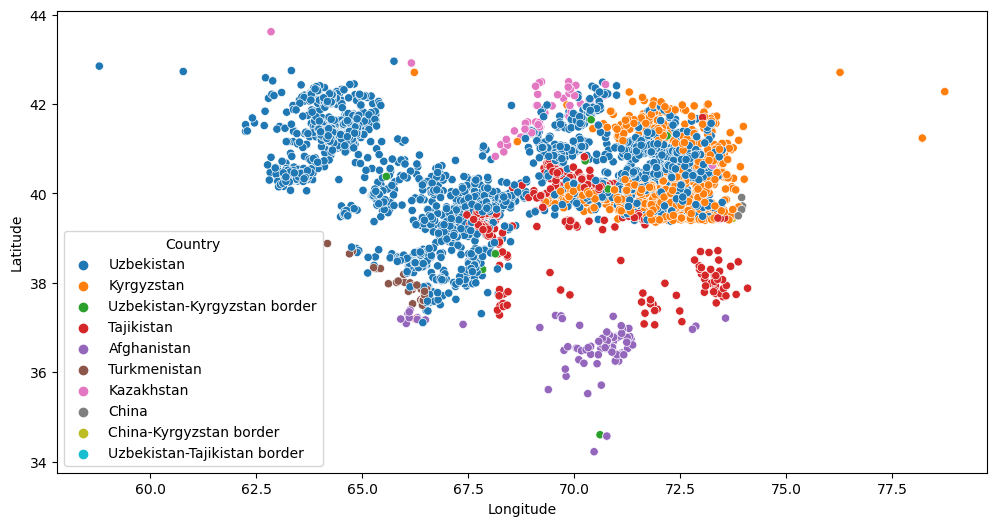

In [7]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Country')
plt.show()

# 🛠️ Preparing Features for Training the Model

Here, I'm preparing my data for model training. First, I drop unnecessary columns ('Date' and 'Time'). Then, I split the data into training and testing sets. After separating the target variable ('Magnitude'), I preprocess the features: numerical attributes are scaled using standard scaling, and categorical attributes ('Country') are one-hot encoded. Finally, I combine these preprocessing steps into a single transformation using a column transformer, and apply it to the training data to get it ready for training the model.

In [8]:
df = df.drop('Date', axis=1)
df = df.drop('Time', axis=1)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

mag = train_set.drop('Magnitude', axis=1)
mag_y = train_set['Magnitude'].copy()

mag_num = mag.drop('Country', axis=1)
mag_cat = mag[['Country']]

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

num_pipeline.fit_transform(mag_num)

num_attr = list(mag_num)
cat_attr = ['Country']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', OneHotEncoder(), cat_attr)
])

mag_prepared = full_pipeline.fit_transform(mag)

# 🤖 Modeling and Prediction

In [9]:
RF_model = RandomForestRegressor()
RF_model.fit(mag_prepared, mag_y)

RandomForestRegressor()

# Data Sampling for Testing 🔗

In [10]:
test_data = mag.sample(20)
test_data.head()

,Latitude,Longitude,Depth,Country
4574,38.55,66.06,16.0,Uzbekistan
1150,39.42,71.67,5.0,Turkmenistan
119,42.26,63.92,2.0,Uzbekistan
1872,40.10,70.37,5.0,Uzbekistan
2306,39.73,72.91,5.0,Kyrgyzstan


# 🔍 Analysis and Results (Prediction)

In [11]:
# Select test data
test_data = mag.sample(20)

# Extract test labels
test_label = mag_y.loc[test_data.index]

# Transform test data
tdp = full_pipeline.transform(test_data)

# Make predictions
predicted_data = RF_model.predict(tdp)

# Compare predictions with actual labels
prediction_df = pd.DataFrame({'Predicted Magnitude':(predicted_data).round(2), 'Real Magnitude': test_label})
prediction_df.head()

,Predicted Magnitude,Real Magnitude
1450,2.18,2.3
2452,2.27,2.2
3430,1.70,1.6
2507,2.11,2.1
2176,2.43,2.6


### 🤖 Predictions
The predicted magnitude provided by the model indicates the expected strength of an earthquake event based on the given features (latitude, longitude, depth, etc.). However, it's important to note that this prediction does not specify when the earthquake will occur. Instead, it estimates the magnitude of the earthquake when it does happen.

### 🔍 Analysis
Let's analyze the first earthquake instance. The model predicts a magnitude of approximately 1.76, based on factors like latitude, longitude, depth, and historical seismic patterns. The actual magnitude, indicated by the real data, is 1.8. This close match suggests the model's accuracy in estimating seismic activity for this instance.

# Save to Google Storage 🪣

In [13]:
prediction_df.to_csv('prediction_results.csv', index=False)

bucket_name = 'quakewatch'
file_name = 'prediction_results.csv'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_name)
blob.upload_from_filename(file_name)

print(f'{file_name} uploaded to {bucket_name}')

prediction_results.csv uploaded to quakewatch


# 📈 Performance Metrics Analysis

In [18]:
# Transform the test set
test_mag_prepared = full_pipeline.transform(test_set.drop('Magnitude', axis=1))

# Predict on the test set
predictions = RF_model.predict(test_mag_prepared)

# Compute R-squared score
r2 = r2_score(test_set['Magnitude'], predictions)
print("R-squared Score: %.5f" % r2)

R-squared Score: 0.44264


The 𝑅<sup>2</sup> score, also known as the coefficient of determination, tells us how well our model explains the variability in the data. In simpler terms, it's like a measure of how close the predicted values are to the actual values. A score of `0` means the model doesn't explain any of the variability, while a score of `1` means it explains all of it. 

In our case, with an 𝑅<sup>2</sup> score of `0.44264`, it means that about `44.26%` of the variation in earthquake magnitudes can be explained by the features your model has considered. So, while it's not perfect, it's still capturing some of the patterns in the data.